In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
import pathlib
import functools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
tf.config.list_physical_devices('GPU')
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
Fri Apr 30 02:05:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/Fire_recogntion_data/fire_test') 
# count the number of fire labels and non fire labels. 
def file_count(path):
  file_count = 0
  dirs = os.listdir(path)
  for dir in dirs:
    dir2 = path.joinpath(dir)  
    if os.path.isdir(dir2):
      file_count += len(os.listdir(dir2))

  return file_count

# Image augmentation to create more fire images
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation((-0.4, 0.4)),
  #layers.experimental.preprocessing.RandomContrast(0.3)
])


def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  """ define loss function total loss = reconstruction loss + kl divergent loss
   𝐿𝑉𝐴𝐸=𝑐⋅𝐿𝐾𝐿+𝐿𝑥(𝑥,𝑥̂ )"""

  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x - x_recon), axis=(1, 2, 3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss, latent_loss


@tf.function
def sampling(inputs):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    z_mean, z_logvar = tf.split(inputs, num_or_size_splits=2, axis=1)
    batch, dim = tf.shape(z_mean)
    epsilon = tf.random.normal(shape=(batch, dim))
    z = z_mean + tf.exp(0.5 * z_logvar) * epsilon
    return z

class Sampling_layer(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs): 
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# make a label dictionary for label names
label_dict = {0: 'no_fire', 1: 'fire'}
label_dict


{0: 'no_fire', 1: 'fire'}

In [ ]:
# check label distribution
fire_path = data_dir/'fire'
fire_image_count = file_count(data_dir/'fire')
nonfire_image_count = file_count(data_dir/'no_fire')
ratio = fire_image_count / nonfire_image_count
print('The number of fire images is', fire_image_count)
print('The number of non fire images is', nonfire_image_count)
print('The ratio of fire image to non-fire image is', round(ratio, 2))

The number of fire images is 1232
The number of non fire images is 1212
The ratio of fire image to non-fire image is 1.02


In [ ]:
img_height = 640
img_width = 480
batch_size = 32

# load fire data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  fire_path, 
  seed=123, label_mode =None,
  image_size=(img_height, img_width),
  batch_size = batch_size, validation_split = 0.2, subset = 'training'
  ).map(lambda x : data_augmentation(x/255.) ).cache().prefetch(2)
train_size = train_ds.cardinality().numpy()
print('Train batches', train_size)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  fire_path, 
  seed=123, label_mode = None,
  image_size=(img_height, img_width),
  batch_size = batch_size, validation_split = 0.2, subset = 'validation', 
  ).map(lambda x: data_augmentation(x/255.) ).cache().prefetch(2)
test_size = test_ds.cardinality().numpy()
print('Test batches', test_size)

Found 1232 files belonging to 6 classes.
Using 986 files for training.
Train batches 31
Found 1232 files belonging to 6 classes.
Using 246 files for validation.
Test batches 8


In [ ]:
train_data = np.stack(list(train_ds.unbatch()))
train_data.shape

(986, 640, 480, 3)

# Build a variational autoencoder to generate new fire images

### Load pretrained convolutional autoencoder, and modified the autoencoder to be a variantional autoencoder

In [ ]:
# load pretrained model and check the structures
fire_only_model_path = '/content/drive/MyDrive/Colab Notebooks/CS767_project/fire_only_model'
pretrained_model = keras.models.load_model(fire_only_model_path)
pretrained_model.encoder.summary()
pretrained_model.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 320, 240, 12)      912       
_________________________________________________________________
batch_normalization_9 (Batch (None, 320, 240, 12)      48        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 120, 24)      7224      
_________________________________________________________________
batch_normalization_10 (Batc (None, 160, 120, 24)      96        
_________________________________________________________________
48filter_layer (Conv2D)      (None, 80, 60, 48)        10416     
_________________________________________________________________
batch_normalization_11 (Batc (None, 80, 60, 48)        192       
_________________________________________________________________
72filter_layer (Conv2D)      (None, 40, 30, 72)       

In [ ]:
def make_vae_encoder(latent_dim):
  """Make VAE encoder by clone pretrained encoder, add three more layers
  Since those conv layers are pretrained, they should be frozen, the model 
  will focuing on training the dense layers
  """
  encoder = keras.models.clone_model(pretrained_model.encoder)
  #[layer.trainable==False for layer in encoder.layers[-4:]]
  encoder.add(layers.Flatten())
  encoder.add(layers.Dense(256, activation='relu'))
  encoder.add(layers.BatchNormalization())
  encoder.add(layers.Dense(latent_dim, activation=None))
  return encoder

### Another encoder with same structure but without pretrained weights for comparison purpose

In [ ]:
def make_encoder2(latent_dim=1):
  """Functional encoder"""
  n_filters = 12
  Conv2D = functools.partial(layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = layers.BatchNormalization
  Flatten = layers.Flatten
  Dense = functools.partial(layers.Dense, activation='relu')
  inputs = layers.Input(shape=(640, 480, 3), name='input')
  x = Conv2D(filters=1*n_filters, kernel_size=5,  strides=2)(inputs)
  x = BatchNormalization()(x)
  
  x = Conv2D(filters=2*n_filters, kernel_size=5,  strides=2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=4*n_filters, kernel_size=3,  strides=2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=6*n_filters, kernel_size=3,  strides=2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8*n_filters, kernel_size=3,  strides=2)(x)
  x = BatchNormalization()(x)

  x = Flatten()(x)
  x = Dense(512)(x)
  x = BatchNormalization()(x)
  x = Dense(latent_dim, activation=None)(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_logvar = layers.Dense(latent_dim, name="z_logvar")(x)
  model = keras.Model(inputs, [z_mean, z_logvar])
  return model

### Decoder has a symmetric structure to the encoder, which is used to reconstruct images from latent space

In [ ]:
def make_decoder():
  n_filters = 12
  BatchNormalization = layers.BatchNormalization()
  Conv2DTranspose = functools.partial(layers.Conv2DTranspose, padding='same', activation='relu')
  Dense = functools.partial(layers.Dense, activation='relu') 
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=20 * 15 * 8 * n_filters),

    layers.Reshape(target_shape=(20, 15, 8 * n_filters)),

    Conv2DTranspose(filters=6*n_filters, kernel_size=3,  strides=2),

    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),

    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
 
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
  
    Conv2DTranspose(filters=3, kernel_size=3,  strides=2, activation='sigmoid'),
  ])
  return decoder

In [ ]:
class VAE(keras.Model):
  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    #self.encoder = make_vae_encoder(self.latent_dim * 2)
    self.encoder = make_encoder2(self.latent_dim)
    self.decoder = make_decoder()
  
  @tf.function
  def sampling(self, z_mean, z_logvar):
      """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
      batch = tf.shape(z_mean)[0]
      dim = tf.shape(z_mean)[1]
      epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
      return z_mean + tf.exp(0.5 * z_logvar) * epsilon

  def encode(self, x):
      """function to encode and split mean and variation vectors"""
      features = self.encoder(x)
      z_mean, z_logvar = tf.split(features, num_or_size_splits=2, axis=1)
      return z_mean, z_logvar

  def decode(self, z):
      return self.decoder(z)

  def vae_loss_function(self, x, x_recon, mu, logsigma, kl_weight=0.0001):
      """ define loss function total loss = reconstruction loss + kl divergent loss
      𝐿𝑉𝐴𝐸=𝑐⋅𝐿𝐾𝐿+𝐿𝑥(𝑥,𝑥̂ )"""
      latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
      reconstruction_loss = tf.reduce_mean(tf.abs(x - x_recon), axis=(1, 2, 3))
      vae_loss = kl_weight * latent_loss + reconstruction_loss
      return vae_loss

  def transform(self, x):
      z_mean, z_logvar = self.encode(x)
      z = self.sampling(z_mean, z_logvar)
      recon = self.decode(z)
      return recon

  def call(self, x):
      #z_mean, z_logvar = self.encode(x)
      z_mean, z_logvar = self.encoder(x)
      z = self.sampling(z_mean, z_logvar)
      recon = self.decode(z)
      loss = self.vae_loss_function(x, recon, z_mean, z_logvar)
      self.add_loss(loss)
      return z_mean, z_logvar, recon

In [ ]:
vae = VAE(200)

In [ ]:
vae.encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 640, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 240, 12) 912         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 240, 12) 48          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 120, 24) 7224        batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
vae.decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (2, None, 28800)          8668800   
_________________________________________________________________
reshape (Reshape)            (2, 20, 15, 96)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (2, 40, 30, 72)           62280     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (2, 80, 60, 48)           31152     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (2, 160, 120, 24)         10392     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (2, 320, 240, 12)         7212      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (2, 640, 480, 3)         

In [ ]:
epochs = 400
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
earlyStopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                              patience=15, restore_best_weights=True)
vae.compile(optimizer=optimizer)

## Training

The training can be done in two ways, one is customized training loop, another one is using default keras model fit. 

In [ ]:
vae.fit(train_data, train_data, batch_size=64, epochs=100, callbacks=earlyStopping)

Epoch 1/100
16/16 [==============================] - 5s 272ms/step - loss: 0.0676
Epoch 2/100
16/16 [==============================] - 4s 272ms/step - loss: 0.0676
Epoch 3/100
16/16 [==============================] - 4s 270ms/step - loss: 0.0676
Epoch 4/100
16/16 [==============================] - 4s 271ms/step - loss: 0.0678
Epoch 5/100
16/16 [==============================] - 4s 271ms/step - loss: 0.0677
Epoch 6/100
16/16 [==============================] - 4s 273ms/step - loss: 0.0676
Epoch 7/100
16/16 [==============================] - 4s 270ms/step - loss: 0.0676
Epoch 8/100
16/16 [==============================] - 4s 273ms/step - loss: 0.0677
Epoch 9/100
16/16 [==============================] - 4s 273ms/step - loss: 0.0677
Epoch 10/100
16/16 [==============================] - 4s 275ms/step - loss: 0.0679
Epoch 11/100
16/16 [==============================] - 4s 275ms/step - loss: 0.0675
Epoch 12/100
16/16 [==============================] - 4s 272ms/step - loss: 0.0677
Epoch 13/100


In [ ]:
# customized training loop
num_epochs = epochs
optimizer = keras.optimizers.Adam(learning_rate=5e-3)

for epoch in range(num_epochs):
    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_ds):
        with tf.GradientTape() as tape:
            z_mean, z_logvar, recon = vae(x_batch_train)
            loss, kl_loss = vae_loss_function(x_batch_train, recon, z_mean, z_logvar)
            print(loss.shape, kl_loss.shape)

        grads = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))

    if epoch % 10 == 0:
      print("epoch %d: mean total loss = %.4f, KL loss = %.4f" % (epoch, 
                                                                      np.mean(loss), np.mean(kl_loss) ))

## Check reconstruction

In [ ]:
# Compare reconstructed images witg orginal images
test_sample = np.stack(list(train_ds.take(1))).squeeze()
temp1, temp2 = vae.encoder(test_sample)
temp2 = vae.sampling(temp1, temp2)
test = vae.decode(temp2)

In [ ]:
temp2 = vae.sampling(temp1, temp2)

In [ ]:
def sample_plot(sample_index, original, restructed):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
  ax1.imshow(original[sample_index].squeeze())
  ax2.imshow(restructed[sample_index].numpy().squeeze())
  plt.show()

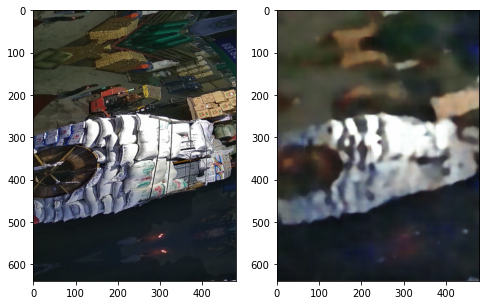

In [ ]:
sample_plot(19, test_sample, test)

In [ ]:
vae.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 28800)             5788800   
_________________________________________________________________
reshape (Reshape)            (None, 20, 15, 96)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 40, 30, 72)        62280     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 80, 60, 48)        31152     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 160, 120, 24)      10392     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 320, 240, 12)      7212      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 640, 480, 3)      

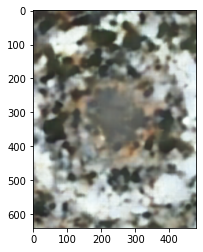

In [ ]:
# generator an image from latent space
test2 = np.random.normal(size=(1, 640, 480, 3))
test2.shape
test_im = vae(test2)[-1]
plt.imshow(test_im.numpy().squeeze())

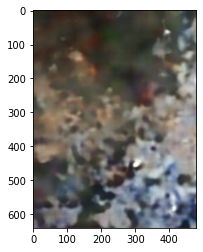

In [ ]:
# Generate images by random mean and variants
test_mean = np.random.normal(size=(1, 200)).astype(np.float32)
test_var = np.random.normal(size=(1, 200)).astype(np.float32)
test_z = vae.sampling(test_mean, test_var)
t3 = vae.decode(test_z)
plt.imshow(t3.numpy().squeeze())

In [ ]:
# vae_path = '/content/drive/MyDrive/Colab Notebooks/fire_project/VAE_model'
# vae.save(vae_path)